In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal
from scipy.stats import zscore
from plotnine import *
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import matplotlib

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["font.size"] = 12

In [3]:
out_dir = Path("OG_data")
out_dir.mkdir(exist_ok=True)

In [4]:
def _runs(arr, val):
    """
    Return a (n, 2) array where rows correspond to the start and stop
    indexes of runs of consecutive values in arr

    Args:
        arr (array-like): array in which to search for runs
        value (float): value for which runs will be searched
    """
    is_val = np.equal(arr, val).view(np.uint8)
    is_val = np.concatenate((np.array([0]), is_val, np.array([0])))
    absdiff = np.abs(np.diff(is_val))
    return np.where(absdiff == 1)[0].reshape(-1, 2)


def mean_bouts(x):
    runs = _runs(x, val=1)
    runs = np.apply_along_axis(lambda x: x[1] - x[0], 1, runs)
    return np.mean(runs)

In [5]:
def cross_correlation(s1, s2, num_lags=None, 
                      standardise=False, standardise_range="all"):
    out = signal.correlate(s1, s2, mode="same")
    if standardise and standardise_range=="all":
        out = zscore(out)
    if num_lags:
        zero_idx = len(out) // 2
        out = out[zero_idx-num_lags:zero_idx+num_lags+1]
    if standardise and standardise_range=="sub":
        out = zscore(out)
    return out

def cc_lags(cc, interval):
    num_lags = len(cc) // 2
    return np.arange(-num_lags, (num_lags + 1)) * interval

def corss_corr_by(x, num_lags=300, standardise=False, standardise_range="all"):
    fps = x.iloc[0].fps
    dem = x.was_freezing_dem.values
    obs = x.was_freezing_obs.values
    zcc = cross_correlation(dem, obs, num_lags=num_lags, standardise=standardise,
                           standardise_range=standardise_range)
    lags = cc_lags(zcc, 1/fps)
    return pd.DataFrame({
        "lag": lags,
        "cc": zcc,
        })

In [6]:
df = pd.read_csv(r"C:\Users\rory\repos\ah_vids\output\OG\conditioning.csv")

# Plots Over Time

In [7]:
def get_freeze_ts(df, rolling_window=10, freeze_col="was_freezing_dem"):
    return (
        df
        .groupby([np.round(df.time)])
        [freeze_col]
        .mean()
        .reset_index()
        .rolling(window=rolling_window)
        .mean()
        .dropna()
        .reset_index(drop=True)
    )

def get_cs_starts():
    return df.loc[lambda x: x.block_type == "CS"]["bin_values"].unique()

def get_cs_stops():
    return get_cs_starts() + 29.9

def get_iti_starts():
    return df.loc[lambda x: x.block_type == "ITI"]["bin_values"].unique()

def get_iti_stops():
    return get_iti_starts() + 9.9

def filler(ax, start, stop, color, alpha, label=None):
    ax.axvspan(start, stop, color=color, alpha=alpha, label=label)
    return ax

def fill_background(ax, cs_color="red", iti_color="grey", alpha=0.2, seconds=False):
    cs_starts = get_cs_starts()
    cs_stops = get_cs_stops()
    iti_starts = get_iti_starts()
    iti_stops = get_iti_stops()
    for i, (start, stop) in enumerate(zip(cs_starts, cs_stops)):
        if i == 0:
            ax = filler(ax, start, stop, cs_color, alpha=alpha, label="CS")
        else:
            ax = filler(ax, start, stop, cs_color, alpha=alpha)
    for i, (start, stop) in enumerate(zip(iti_starts, iti_stops)):
        if i == 0:
            ax = filler(ax, start, stop, iti_color, alpha=alpha, label="ITI")
        else: 
            ax = filler(ax, start, stop, iti_color, alpha=alpha)
    ax.legend()
    return ax

### Freezing Over Time

Text(0.5, 0, 'Time [mins]')

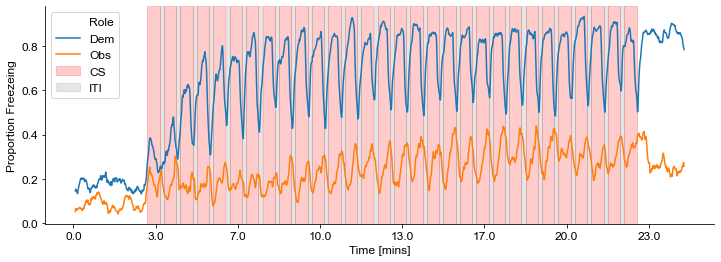

In [8]:
freeze_ts_dem = get_freeze_ts(df)
freeze_ts_obs = get_freeze_ts(df, freeze_col="was_freezing_obs")

df_both = (
    pd.merge(freeze_ts_dem, freeze_ts_obs)
    .rename(columns={"was_freezing_dem": "Dem", "was_freezing_obs": "Obs"})
    .melt(id_vars="time", var_name="Role", value_name="Freeze")
)

f, ax = plt.subplots(figsize=(12, 4))
ax = fill_background(ax)
ax = sns.lineplot(data=df_both, x="time", 
                  y="Freeze",
                  hue="Role",
                  ci=None,
                  ax=ax)
sns.despine()
ax.set_ylabel("Proportion Freezeing")
ax.set_xticklabels(np.round(ax.get_xticks() / 60))
ax.set_xlabel("Time [mins]")

### Correlation Over Time

Text(0.5, 0, 'Time [mins]')

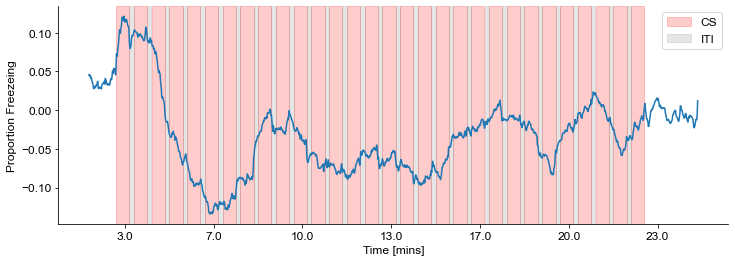

In [9]:
def get_corr_ts(df, rolling_window=10):
    grouped = (
        df
        .groupby([df.mouse_name, np.round(df.time)])
        [["was_freezing_dem", "was_freezing_obs"]]
        .mean()
        .reset_index()
    )
    frames = []
    for name in grouped.mouse_name.unique():
        dfs = grouped.loc[lambda x: x.mouse_name == name].copy()
        dfs = dfs.assign(rolling_corr = dfs['was_freezing_dem']
            .rolling(rolling_window)
            .corr(dfs['was_freezing_obs']))
        frames.append(dfs)
    df_corr = pd.concat(frames)

    return df_corr



df_corr = get_corr_ts(df, rolling_window=120)

f, ax = plt.subplots(figsize=(12, 4))
ax = fill_background(ax)
ax = sns.lineplot(data=df_corr, 
                  x="time", 
                  y="rolling_corr",
                  ax=ax, ci=None)
sns.despine()
ax.set_ylabel("Proportion Freezeing")
ax.set_xticklabels(np.round(ax.get_xticks() / 60))
ax.set_xlabel("Time [mins]")

# Bouts

In [10]:
bouts = (
    df
    .groupby(["mouse_name"])
    .apply(lambda x: mean_bouts(x.was_freezing_obs))
    .reset_index().rename(columns={0: "mean_bout"})
    .merge(df[["mouse_name", "fps"]].drop_duplicates())
    .assign(mean_bout=lambda x: x.mean_bout / x.fps)
    .assign(time_period="overall")
)

bouts_tt = (
    df
    .groupby(["mouse_name", "block_type"])
    .apply(lambda x: mean_bouts(x.was_freezing_obs))
    .reset_index().rename(columns={0: "mean_bout"})
    .merge(df[["mouse_name", "fps"]].drop_duplicates())
    .assign(mean_bout=lambda x: x.mean_bout / x.fps)
    .assign(time_period="overall")
)

bouts_ff = (
    df
        .dropna()
        .loc[lambda x: x.trial_num <= 5]
        .groupby(["mouse_name", "block_type"])
        .apply(lambda x: mean_bouts(x.was_freezing_obs))
        .reset_index().rename(columns={0: "mean_bout"})
        .merge(df[["mouse_name", "fps"]].drop_duplicates())
        .assign(mean_bout=lambda x: x.mean_bout / x.fps)
        .assign(time_period="First 5")
)
bouts_lf = (
    df
        .loc[lambda x: x.trial_num >= (x.trial_num.max() - 6)]
        .groupby(["mouse_name", "block_type"])
        .apply(lambda x: mean_bouts(x.was_freezing_obs))
        .reset_index().rename(columns={0: "mean_bout"})
        .merge(df[["mouse_name", "fps"]].drop_duplicates())
        .assign(mean_bout=lambda x: x.mean_bout / x.fps)
        .assign(time_period="Last 5")
)
bouts_fflf = pd.concat([bouts_ff, bouts_lf])

In [11]:
bouts.to_csv(out_dir / "bouts_overall.csv", index=False)
bouts_tt.to_csv(out_dir / "bouts_tt.csv", index=False)
bouts_fflf.to_csv(out_dir / "bouts_fflf.csv", index=False)

# Overall Freeze Duration

In [12]:
df_y =  (
    df
    .loc[lambda x: (x.block_type == "CS")]
    .groupby("mouse_name")
    .apply(lambda x: np.mean(x.was_freezing_obs))
    .reset_index()
    .rename(columns={0: "CS_FreezeAve"})
)

df_y = (
    df
    .loc[lambda x: (x.block_type == "CS") & (x.trial_num >= (x.trial_num.max() - 5))]
    .groupby("mouse_name")
    .apply(lambda x: np.mean(x.was_freezing_obs))
    .reset_index()
    .rename(columns={0: "CS_last5"})
    .merge(df_y)
)

df_y = (
    df
    .groupby("mouse_name")
    .apply(lambda x: np.mean(x.was_freezing_obs))
    .reset_index()
    .rename(columns={0: "overall_freeze"})
    .merge(df_y)
)

df_y.head()

,mouse_name,overall_freeze,CS_last5,CS_FreezeAve
0,Fos Only OFL 1,0.260891,0.472407,0.311852
1,Fos Only OFL 1(0),0.250755,0.505926,0.242074
2,Fos Only OFL 1(1),0.248747,0.343889,0.282296
3,Fos Only OFL 1(2),0.217655,0.206111,0.198333
4,Fos Only OFL 1_2,0.230819,0.421111,0.232556


# Cross Correlation

## Entire Session

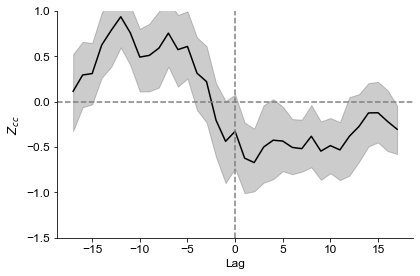

In [64]:
df_cc_session = (
    df
    .groupby(["mouse_name"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=500, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name,np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

ax= sns.lineplot(
    data=df_cc_session, 
    x="lag",
    y="cc",
    color="black"
)

ax.set_ylim(-1.5, 1)
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)

plt.tight_layout()
plt.savefig("overall.svg", dpi=300)

## Block Throughout Session

In [74]:
df_cc_block = (
    df
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=299, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

#### CS

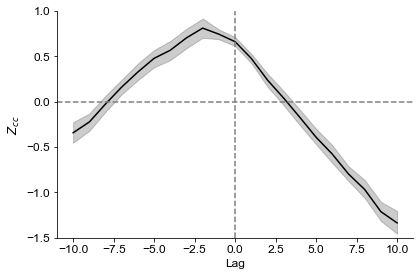

In [75]:
ax= sns.lineplot(
    data=df_cc_block.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

ax.set_ylim(-1.5, 1)
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)

plt.tight_layout()
plt.savefig("CS.svg", dpi=300)

#### Quantify Obs leading

In [76]:
from sklearn.metrics import auc
import statsmodels.formula.api as smf


def auc_leftright_nop(cc, lags):
    left_auc = auc(lags[lags < 0], cc[lags < 0])
    right_auc = auc(lags[lags > 0], cc[lags > 0])
    return left_auc - right_auc


df_cs_lr = (
    df_cc_block
    .loc[lambda x: x.block_type == "CS"]
    .groupby("mouse_name")
    .apply(lambda x: auc_leftright_nop(x.cc, x.lag))
    .reset_index()
    .rename(columns={0:"left_right"})
    .merge(df_y[["mouse_name", "CS_last5"]])
)


model = smf.ols(formula="CS_last5 ~ left_right", data=df_cs_lr)
res = model.fit()
res.summary()

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CS_last5   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.725
Date:                Fri, 04 Sep 2020   Prob (F-statistic):             0.0442
Time:                        13:58:39   Log-Likelihood:                 20.767
No. Observations:                  19   AIC:                            -37.53
Df Residuals:                      17   BIC:                            -35.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1962      0.050      3.946      0.001       0.091       0.301
left_right     0.0137      0.006      2.174      0.044       0.000       0.027
==============================================================================
Omnibus:                        2.489   Durbin-Watson:                   1.447
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                1.054
Skew:                           0.534   Prob(JB):                        0.590
Kurtosis:                       3.437   Cond. No.                         20.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ITI

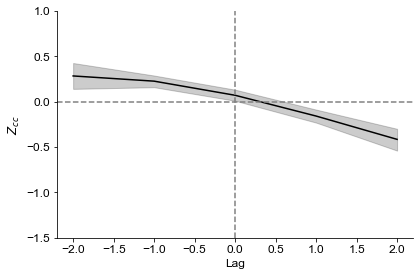

In [27]:
ax= sns.lineplot(
    data=df_cc.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)


ax.set_ylim(-1.5, 1)
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)

plt.tight_layout()
plt.savefig("ITI.svg", dpi=300)

#### Baseline

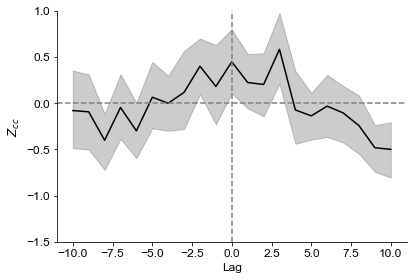

In [77]:
ax = (
    df
    .loc[lambda x: x.block_type == "Baseline"]
    .groupby("mouse_name")
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=299, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([np.round(x.lag), x.mouse_name]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
    .pipe(
        lambda x: 
        sns.lineplot(
        data=x, 
        x="lag",
        y="cc",
        color="black"
        )
    )
)

ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("Baseline.svg", dpi=300)

#### US

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


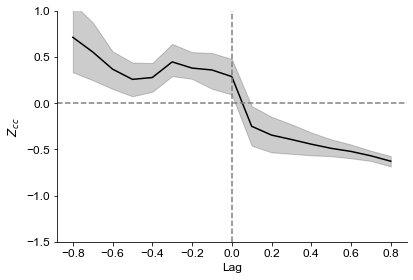

In [13]:
ax = (
    df
    .dropna()
    .loc[lambda x: x.block_type == "CS"]
    .loc[lambda x: x.aligned >= 28]
    .groupby(["mouse_name", "trial_num"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=25, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, np.round(x.lag, 1)]))
    .mean()
    .drop(["lag", "trial_num"], axis=1)
    .reset_index()
    .drop("level_2", axis=1)
    .pipe(
        lambda x: sns.lineplot(data=x, x="lag", y="cc", color="black")
    )
)

# ax.set_title("US")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("US.svg", dpi=300)

### First 5 Trials

In [30]:
df_ccff = (
    df
    .loc[lambda x: x.trial_num <= 5]
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=299, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


#### CS

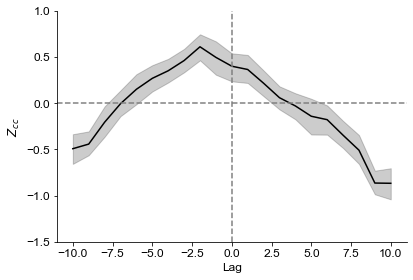

In [31]:
ax= sns.lineplot(
    data=df_ccff.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("CS_First5.svg", dpi=300)

#### ITI

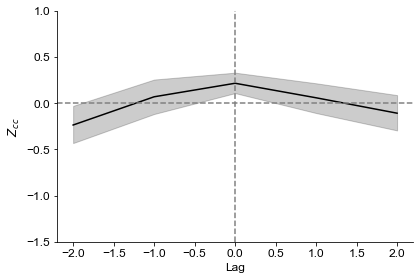

In [32]:
ax= sns.lineplot(
    data=df_ccff.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("First 5 ITI")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("ITI_First5.svg", dpi=300)

### Last 5 Trials

In [33]:
df_cclf = (
    df
    .loc[lambda x: x.trial_num >= (x.trial_num.max() - 5)]
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=299, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


#### CS

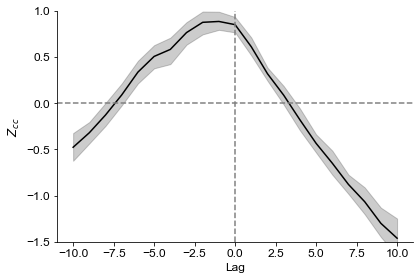

In [34]:
ax= sns.lineplot(
    data=df_cclf.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("Last 5 CS")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("CS_Last5.svg", dpi=300)

#### ITI

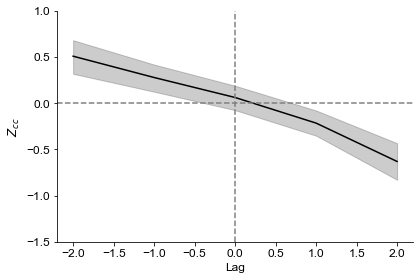

In [35]:
ax= sns.lineplot(
    data=df_cclf.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("Last 5 ITI")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("ITI_Last5.svg", dpi=300)

## First 5 Seconds

In [78]:
df_cc_fsec = (
    df
    .loc[lambda x: x.aligned < 5]
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=70, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag, 1)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


#### CS

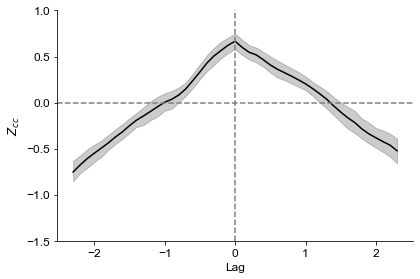

In [79]:
ax= sns.lineplot(
    data=df_cc_fsec.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("CS: First 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("CS_First5Sec.svg", dpi=300)

#### ITI

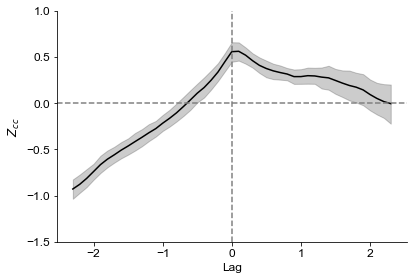

In [80]:
ax= sns.lineplot(
    data=df_cc_fsec.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("ITI: First 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("ITI_First5Sec.svg", dpi=300)

### Last Five Seconds

In [82]:
df_cc_lsec = (
    df
    .loc[lambda x: ((x.block_type == "CS") & (x.aligned >= 25)) | ((x.block_type == "ITI") & (x.aligned >= 5))  ]
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=70, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag, 1)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


#### CS

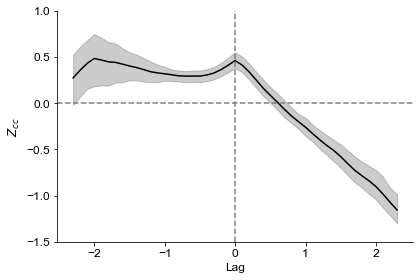

In [83]:
ax= sns.lineplot(
    data=df_cc_lsec.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("CS: Last 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
plt.savefig("CS_Last5Sec.svg", dpi=300)

#### ITI

Text(0.5, 1.0, 'Last 5 Seconds of ITI\n All Trials')

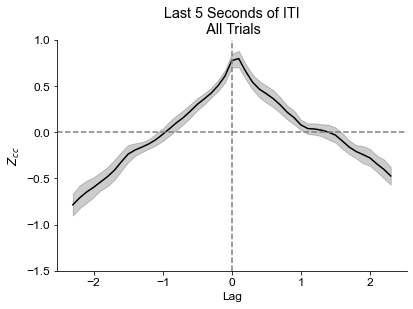

In [96]:
ax= sns.lineplot(
    data=df_cc_lsec.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("ITI: Last 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
ax.set_title("Last 5 Seconds of ITI\n All Trials")
# plt.savefig("ITI_Last5Sec.svg", dpi=300)

### Last 5 secs in first 5 trials 

In [86]:
df_ff_lsec = (
    df
    .loc[lambda x: x.trial_num <= 5]
    .loc[lambda x: ((x.block_type == "CS") & (x.aligned >= 25)) | ((x.block_type == "ITI") & (x.aligned >= 5))  ]
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=70, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag, 1)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)


c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


#### CS

(-1.5, 1.0)

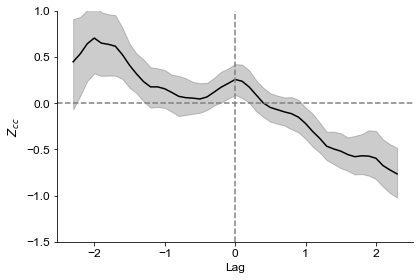

In [97]:
ax= sns.lineplot(
    data=df_ff_lsec.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("CS: Last 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
# plt.savefig("CS_Last5Sec.svg", dpi=300)

#### ITI

Text(0.5, 1.0, 'Last 5 Seconds of ITI\nFirst 5 Trials')

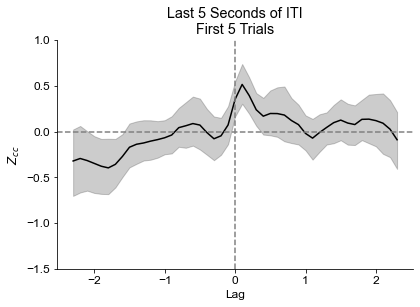

In [98]:
ax= sns.lineplot(
    data=df_ff_lsec.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("CS: Last 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
ax.set_title("Last 5 Seconds of ITI\nFirst 5 Trials")

### Last 5 secs in last 5 trials 

In [89]:
df_lf_lsec = (
    df
    .loc[lambda x: x.trial_num >= (x.trial_num.max() - 5)]
    .loc[lambda x: ((x.block_type == "CS") & (x.aligned >= 25)) | ((x.block_type == "ITI") & (x.aligned >= 5))  ]
    .groupby(["mouse_name", "trial_num", "block_type"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=70, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.block_type, np.round(x.lag, 1)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)


c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


#### CS

(-1.5, 1.0)

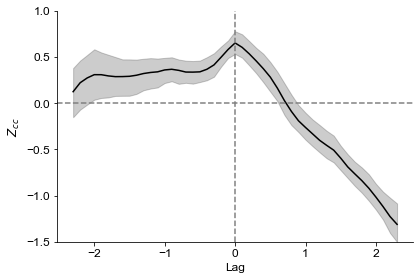

In [91]:
ax= sns.lineplot(
    data=df_lf_lsec.loc[lambda x: x.block_type == "CS"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("CS: Last 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)

#### ITI

Text(0.5, 1.0, 'Last 5 Seconds of ITI\nLast 5 Trials')

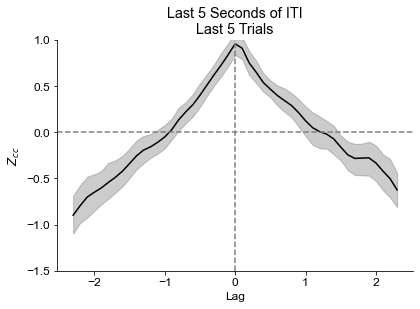

In [99]:
ax= sns.lineplot(
    data=df_lf_lsec.loc[lambda x: x.block_type == "ITI"], 
    x="lag",
    y="cc",
    color="black"
)

# ax.set_title("CS: Last 5 Seconds")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.tight_layout()
ax.set_ylim(-1.5, 1)
ax.set_title("Last 5 Seconds of ITI\nLast 5 Trials")

# Compare


In [43]:
df_y =  (
    df
    .loc[lambda x: (x.block_type == "CS")]
    .groupby("mouse_name")
    .apply(lambda x: np.mean(x.was_freezing_obs))
    .reset_index()
    .rename(columns={0: "CS_FreezeAve"})
)

df_y = (
    df
    .loc[lambda x: (x.block_type == "CS") & (x.trial_num >= (x.trial_num.max() - 5))]
    .groupby("mouse_name")
    .apply(lambda x: np.mean(x.was_freezing_obs))
    .reset_index()
    .rename(columns={0: "CS_last5"})
    .merge(df_y)
)

df_y = (
    df
    .groupby("mouse_name")
    .apply(lambda x: np.mean(x.was_freezing_obs))
    .reset_index()
    .rename(columns={0: "overall_freeze"})
    .merge(df_y)
)


In [44]:
df_y.head()

,mouse_name,overall_freeze,CS_last5,CS_FreezeAve
0,Fos Only OFL 1,0.260891,0.472407,0.311852
1,Fos Only OFL 1(0),0.250755,0.505926,0.242074
2,Fos Only OFL 1(1),0.248747,0.343889,0.282296
3,Fos Only OFL 1(2),0.217655,0.206111,0.198333
4,Fos Only OFL 1_2,0.230819,0.421111,0.232556


In [45]:
df_cs_counts = (
    df
    .groupby(["mouse_name", "trial_num"])
    [["was_freezing_dem", "was_freezing_obs"]]
    .mean()
    .reset_index()
    .groupby("mouse_name")
    [["was_freezing_dem", "was_freezing_obs"]]
    .corr()
    .reset_index()
    .iloc[0::2,:]
    .rename(columns={"was_freezing_obs": "CS_freeze_corr"})
    .loc[:, ["mouse_name", "CS_freeze_corr"]]
    .merge(df_y)
)

In [46]:
pearsonr(df_cs_counts["CS_freeze_corr"], df_cs_counts["CS_last5"])

(0.47289169667551223, 0.040877590948290604)

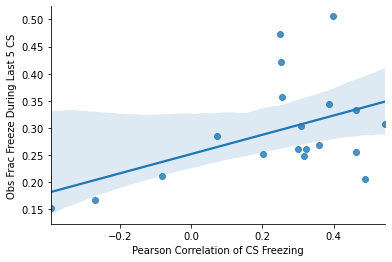

In [47]:
ax = sns.regplot(data=df_cs_counts, x="CS_freeze_corr", y="CS_last5")

ax.set_ylabel("Obs Frac Freeze During Last 5 CS")
ax.set_xlabel("Pearson Correlation of CS Freezing")
sns.despine()

In [48]:
model = smf.ols(formula="CS_last5 ~ CS_freeze_corr", data=df_cs_counts)
res = model.fit()
res.summary()


c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CS_last5   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     4.897
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0409
Time:                        17:06:27   Log-Likelihood:                 20.842
No. Observations:                  19   AIC:                            -37.68
Df Residuals:                      17   BIC:                            -35.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2520      0.028      9.089      0.000       0.193       0.310
CS_freeze_corr     0.1778      0.080      2.213      0.041       0.008       0.347
==============================================================================
Omnibus:                        5.273   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.377
Skew:                           1.017   Prob(JB):                        0.185
Kurtosis:                       3.354   Cond. No.                         4.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
(
    df_cs_counts
    .assign(CS_pctFreeze_last5=lambda x: x["CS_last5"] * 100)
    .drop(["overall_freeze", "CS_FreezeAve", "CS_last5"], axis=1)
    .rename({
        "CS_freeze_corr": "TrialxTrial_CSFreezeCorrelation",
    })
    .to_excel("TrialxTrial.xlsx", index=False)
)

In [54]:
df_cs_counts.CS_last5

0     0.472407
1     0.505926
2     0.343889
3     0.206111
4     0.421111
5     0.332407
6     0.261481
7     0.302963
8     0.210741
9     0.168148
10    0.306852
11    0.252963
12    0.284444
13    0.151852
14    0.249259
15    0.356481
16    0.260556
17    0.269259
18    0.255370
Name: CS_last5, dtype: float64